# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Apr  9 09:33:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

In [ ]:
import PIL
print(PIL.__version__)

9.4.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!gdown 1RxBQiZgRAfio2tWhEE7lzZ6IaJzLheH1

Downloading...
From (original): https://drive.google.com/uc?id=1RxBQiZgRAfio2tWhEE7lzZ6IaJzLheH1
From (redirected): https://drive.google.com/uc?id=1RxBQiZgRAfio2tWhEE7lzZ6IaJzLheH1&confirm=t&uuid=a6a748ed-3e0c-4b60-a70b-4fbb60e8fac9
To: /content/journey-springfield.zip
100% 546M/546M [00:04<00:00, 110MB/s]


In [ ]:
#!unzip -q /content/gdrive/MyDrive/journey-springfield.zip
!unzip -q /content/journey-springfield.zip

In [ ]:
!ls train

simpsons_dataset


В датасете 42 персонажа, то есть 42 класса. Для некоторых из персонажей количество обучающих примеров очень мало, не более 100.

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
# DEVICE = torch.device("cuda")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            # название последнего каталога в пути
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)     # подаётся numpy-array
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
# определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [ ]:
# файлы, которые подходят под определенную маску (.jpg)
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
train_val_files[:5]

[PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg'),
 PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0001.jpg'),
 PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0002.jpg'),
 PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0003.jpg'),
 PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0004.jpg')]

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

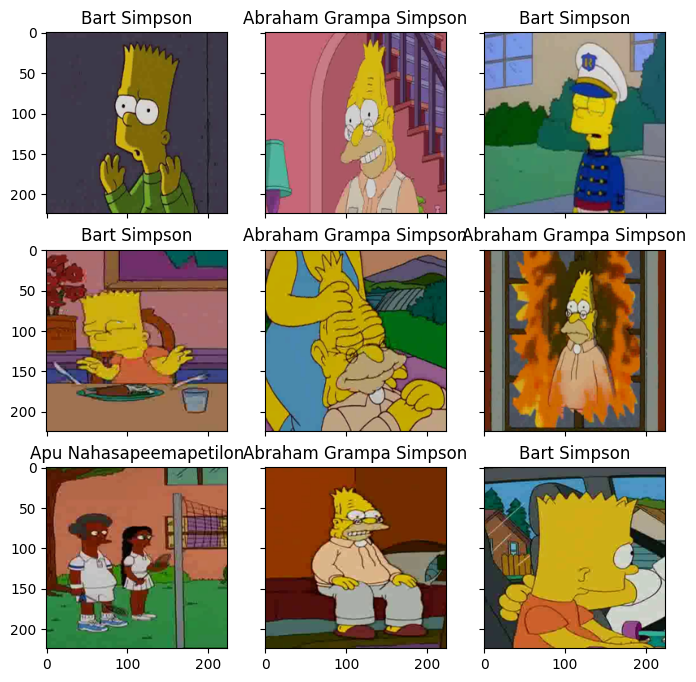

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))    # 42
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42


Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.6362445712112317


epoch:  50%|█████     | 1/2 [02:04<02:04, 124.56s/it]


Epoch 001 train_loss: 2.6362     val_loss 2.0034 train_acc 0.2621 val_acc 0.4488
loss 1.5596892638254776


epoch: 100%|██████████| 2/2 [04:06<00:00, 123.04s/it]


Epoch 002 train_loss: 1.5597     val_loss 1.2690 train_acc 0.5738 val_acc 0.6655


Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

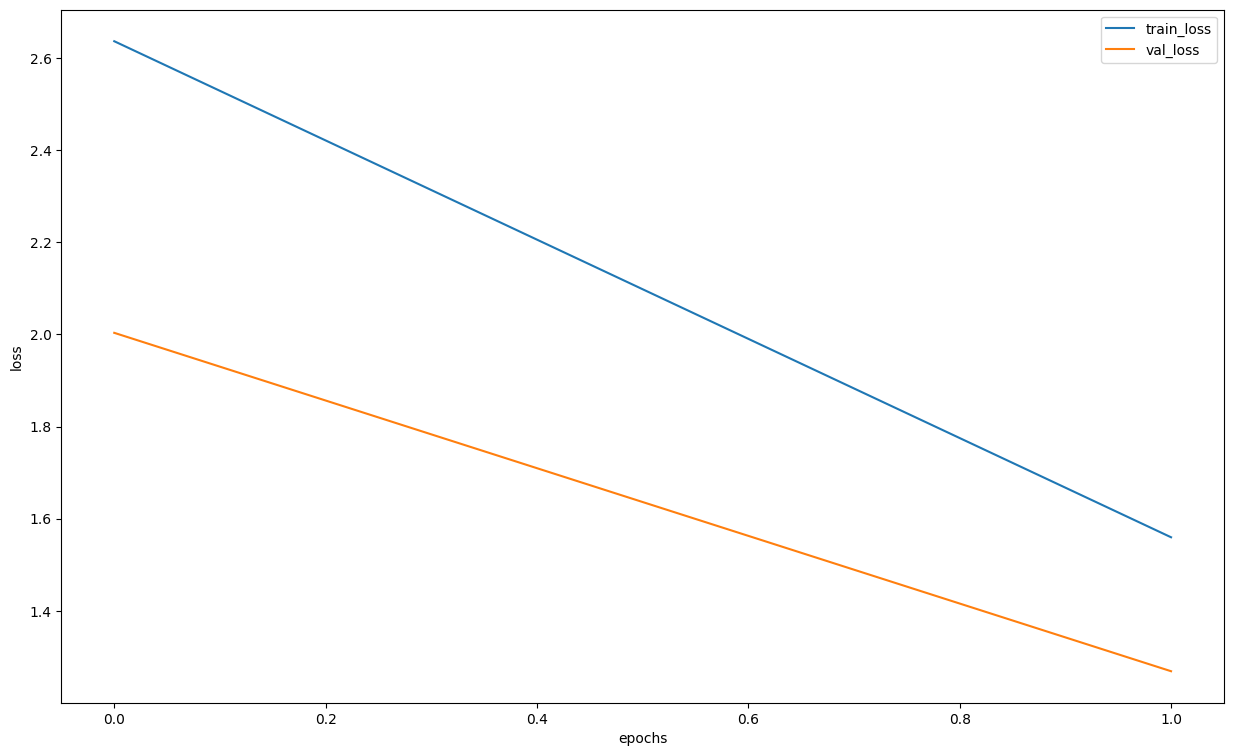

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.55


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

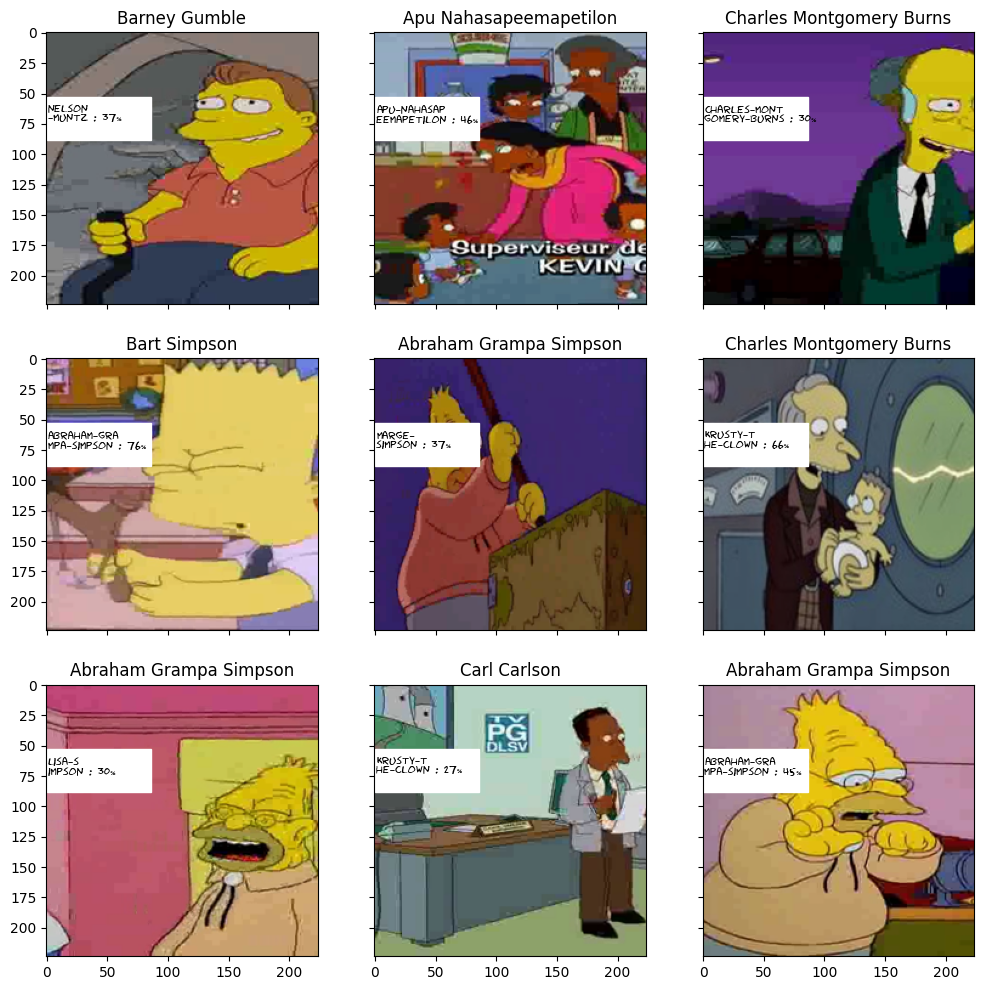

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls

gdrive	label_encoder.pkl  sample_data	sample_submission.csv  testset	train


In [ ]:
import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


## Экспериментируем с простой сетью

- **Больше эпох**

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=20, batch_size=64)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 1.015026925411093


epoch:   5%|▌         | 1/20 [02:04<39:25, 124.51s/it]


Epoch 001 train_loss: 1.0150     val_loss 1.0133 train_acc 0.7221 val_acc 0.7306
loss 0.7185005766547055


epoch:  10%|█         | 2/20 [04:08<37:18, 124.34s/it]


Epoch 002 train_loss: 0.7185     val_loss 0.8955 train_acc 0.7996 val_acc 0.7698
loss 0.5167870288104326


epoch:  15%|█▌        | 3/20 [06:13<35:18, 124.63s/it]


Epoch 003 train_loss: 0.5168     val_loss 0.9179 train_acc 0.8544 val_acc 0.7660
loss 0.3885872556290905


epoch:  20%|██        | 4/20 [08:25<33:58, 127.40s/it]


Epoch 004 train_loss: 0.3886     val_loss 0.8914 train_acc 0.8848 val_acc 0.7889
loss 0.2930504302741904


epoch:  25%|██▌       | 5/20 [10:29<31:33, 126.26s/it]


Epoch 005 train_loss: 0.2931     val_loss 0.9155 train_acc 0.9112 val_acc 0.7921
loss 0.2100074908062716


epoch:  30%|███       | 6/20 [12:33<29:16, 125.50s/it]


Epoch 006 train_loss: 0.2100     val_loss 1.0604 train_acc 0.9358 val_acc 0.7956
loss 0.16454639410477503


epoch:  35%|███▌      | 7/20 [14:36<27:00, 124.67s/it]


Epoch 007 train_loss: 0.1645     val_loss 1.0969 train_acc 0.9501 val_acc 0.7971
loss 0.1254128092310597


epoch:  40%|████      | 8/20 [16:41<24:55, 124.61s/it]


Epoch 008 train_loss: 0.1254     val_loss 1.1876 train_acc 0.9613 val_acc 0.7950
loss 0.11283973153005222


epoch:  45%|████▌     | 9/20 [18:45<22:48, 124.44s/it]


Epoch 009 train_loss: 0.1128     val_loss 1.2876 train_acc 0.9638 val_acc 0.8044
loss 0.09268118748140568


epoch:  50%|█████     | 10/20 [20:50<20:46, 124.62s/it]


Epoch 010 train_loss: 0.0927     val_loss 1.3071 train_acc 0.9683 val_acc 0.8000
loss 0.0896943674764327


epoch:  55%|█████▌    | 11/20 [22:54<18:40, 124.47s/it]


Epoch 011 train_loss: 0.0897     val_loss 1.4617 train_acc 0.9703 val_acc 0.8000
loss 0.06341777351158727


epoch:  60%|██████    | 12/20 [24:59<16:36, 124.57s/it]


Epoch 012 train_loss: 0.0634     val_loss 1.6310 train_acc 0.9808 val_acc 0.8036
loss 0.08083303077288194


epoch:  65%|██████▌   | 13/20 [27:04<14:32, 124.69s/it]


Epoch 013 train_loss: 0.0808     val_loss 1.4959 train_acc 0.9739 val_acc 0.8028
loss 0.07053699602098691


epoch:  70%|███████   | 14/20 [29:08<12:27, 124.57s/it]


Epoch 014 train_loss: 0.0705     val_loss 1.5226 train_acc 0.9771 val_acc 0.8038
loss 0.07169510121776143


epoch:  75%|███████▌  | 15/20 [31:13<10:23, 124.64s/it]


Epoch 015 train_loss: 0.0717     val_loss 1.5033 train_acc 0.9775 val_acc 0.8147
loss 0.05807192373696433


epoch:  80%|████████  | 16/20 [33:17<08:18, 124.51s/it]


Epoch 016 train_loss: 0.0581     val_loss 1.5859 train_acc 0.9816 val_acc 0.8070
loss 0.06285198391133985


epoch:  85%|████████▌ | 17/20 [35:20<06:12, 124.15s/it]


Epoch 017 train_loss: 0.0629     val_loss 1.5447 train_acc 0.9795 val_acc 0.8009
loss 0.04741566834865831


epoch:  90%|█████████ | 18/20 [37:23<04:07, 123.62s/it]


Epoch 018 train_loss: 0.0474     val_loss 1.6117 train_acc 0.9853 val_acc 0.8065
loss 0.05606401205920449


epoch:  95%|█████████▌| 19/20 [39:25<02:03, 123.36s/it]


Epoch 019 train_loss: 0.0561     val_loss 1.8741 train_acc 0.9830 val_acc 0.7875
loss 0.03339065989503508


epoch: 100%|██████████| 20/20 [41:29<00:00, 124.50s/it]


Epoch 020 train_loss: 0.0334     val_loss 1.8135 train_acc 0.9903 val_acc 0.8172


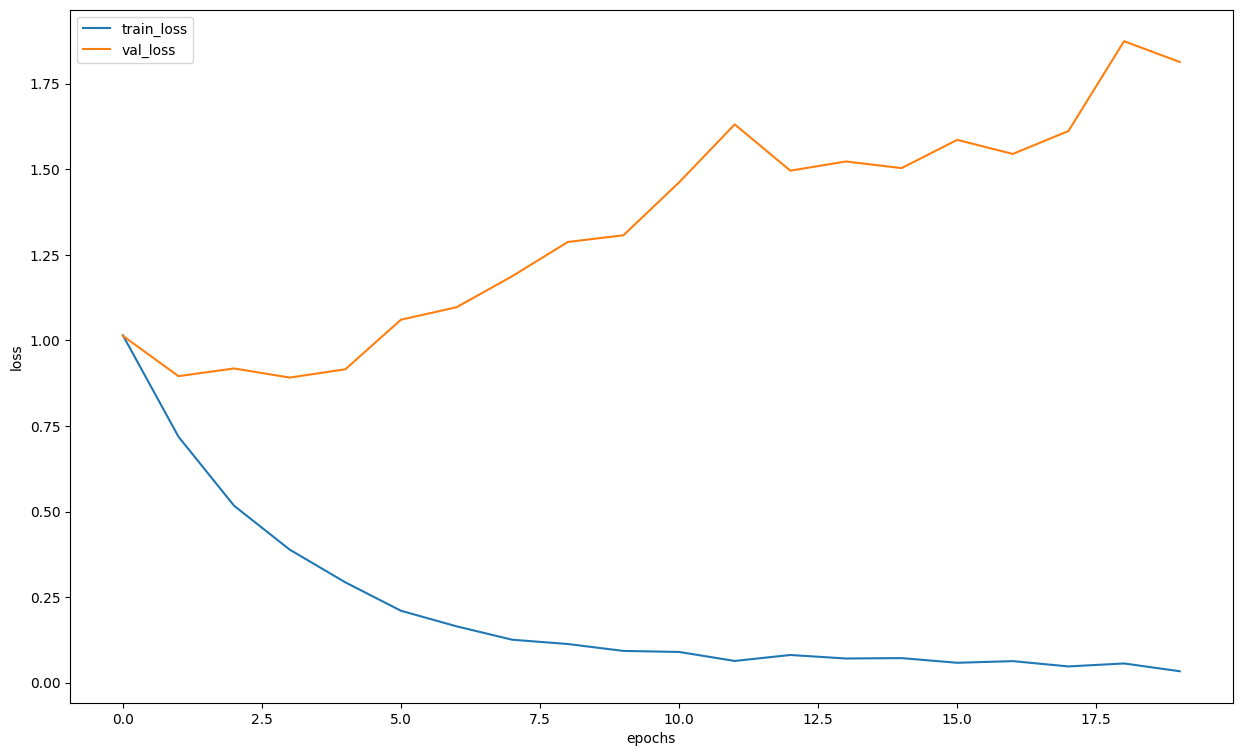

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
probs_ims = predict(simple_cnn, imgs)
y_pred = np.argmax(probs_ims,-1)

f1 = f1_score(actual_labels, y_pred, average='micro')
print("F1-оценка:", f1)

F1-оценка: 0.65


- **Размер фильтров**  
Попробуем использовать больший размер фильтров (5 на 5), так как имеющиеся у нас изображения в основном крупноплановые.

In [ ]:
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 3 * 3, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Обучение
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=22, batch_size=64)

epoch:   0%|          | 0/22 [00:00<?, ?it/s]

loss 2.559675053173026


epoch:   5%|▍         | 1/22 [13:31<4:43:55, 811.19s/it]


Epoch 001 train_loss: 2.5597     val_loss 1.9485 train_acc 0.2880 val_acc 0.4545
loss 1.6064338548918942


epoch:   9%|▉         | 2/22 [26:37<4:25:30, 796.51s/it]


Epoch 002 train_loss: 1.6064     val_loss 1.3594 train_acc 0.5551 val_acc 0.6229
loss 1.1066620232717377


epoch:  14%|█▎        | 3/22 [40:21<4:16:09, 808.94s/it]


Epoch 003 train_loss: 1.1067     val_loss 1.1381 train_acc 0.6908 val_acc 0.6821
loss 0.823177451092359


epoch:  18%|█▊        | 4/22 [53:29<4:00:12, 800.72s/it]


Epoch 004 train_loss: 0.8232     val_loss 1.0650 train_acc 0.7648 val_acc 0.7119
loss 0.6217631426531233


epoch:  23%|██▎       | 5/22 [1:06:26<3:44:27, 792.19s/it]


Epoch 005 train_loss: 0.6218     val_loss 0.9324 train_acc 0.8218 val_acc 0.7596
loss 0.4827777613112179


epoch:  27%|██▋       | 6/22 [1:19:27<3:30:16, 788.56s/it]


Epoch 006 train_loss: 0.4828     val_loss 0.9112 train_acc 0.8570 val_acc 0.7761
loss 0.3650714377664716


epoch:  32%|███▏      | 7/22 [1:32:43<3:17:41, 790.75s/it]


Epoch 007 train_loss: 0.3651     val_loss 0.9794 train_acc 0.8906 val_acc 0.7841
loss 0.2932710644972766


epoch:  36%|███▋      | 8/22 [1:45:53<3:04:28, 790.64s/it]


Epoch 008 train_loss: 0.2933     val_loss 1.0102 train_acc 0.9106 val_acc 0.7902
loss 0.22234317739941148


epoch:  41%|████      | 9/22 [1:58:54<2:50:39, 787.69s/it]


Epoch 009 train_loss: 0.2223     val_loss 1.0903 train_acc 0.9306 val_acc 0.7786
loss 0.18580579870168143


epoch:  45%|████▌     | 10/22 [2:12:15<2:38:21, 791.76s/it]


Epoch 010 train_loss: 0.1858     val_loss 1.2124 train_acc 0.9410 val_acc 0.7916
loss 0.17257084386296634


epoch:  50%|█████     | 11/22 [2:26:07<2:27:24, 804.04s/it]


Epoch 011 train_loss: 0.1726     val_loss 1.2330 train_acc 0.9473 val_acc 0.7726
loss 0.14298176961257522


epoch:  55%|█████▍    | 12/22 [2:39:54<2:15:09, 810.92s/it]


Epoch 012 train_loss: 0.1430     val_loss 1.3221 train_acc 0.9560 val_acc 0.7982
loss 0.13215430478311904


epoch:  59%|█████▉    | 13/22 [2:53:25<2:01:40, 811.14s/it]


Epoch 013 train_loss: 0.1322     val_loss 1.4126 train_acc 0.9583 val_acc 0.7784
loss 0.11422796848777206


epoch:  64%|██████▎   | 14/22 [3:06:43<1:47:37, 807.17s/it]


Epoch 014 train_loss: 0.1142     val_loss 1.3792 train_acc 0.9655 val_acc 0.7818
loss 0.11646920520508773


epoch:  68%|██████▊   | 15/22 [3:20:23<1:34:36, 810.97s/it]


Epoch 015 train_loss: 0.1165     val_loss 1.3076 train_acc 0.9629 val_acc 0.8047
loss 0.09960185396991358


epoch:  73%|███████▎  | 16/22 [3:34:05<1:21:26, 814.39s/it]


Epoch 016 train_loss: 0.0996     val_loss 1.4931 train_acc 0.9703 val_acc 0.7879
loss 0.08980034660974864


epoch:  77%|███████▋  | 17/22 [3:47:21<1:07:23, 808.67s/it]


Epoch 017 train_loss: 0.0898     val_loss 1.7082 train_acc 0.9736 val_acc 0.7703
loss 0.09672142385923788


epoch:  82%|████████▏ | 18/22 [4:00:28<53:28, 802.14s/it]


Epoch 018 train_loss: 0.0967     val_loss 1.6201 train_acc 0.9709 val_acc 0.7958
loss 0.0938266629144465


epoch:  86%|████████▋ | 19/22 [4:13:30<39:48, 796.12s/it]


Epoch 019 train_loss: 0.0938     val_loss 1.6000 train_acc 0.9725 val_acc 0.7684
loss 0.10163032873127595


epoch:  91%|█████████ | 20/22 [4:26:28<26:21, 790.77s/it]


Epoch 020 train_loss: 0.1016     val_loss 1.5503 train_acc 0.9693 val_acc 0.7986
loss 0.05968774945251036


epoch:  95%|█████████▌| 21/22 [4:39:43<13:12, 792.02s/it]


Epoch 021 train_loss: 0.0597     val_loss 1.9834 train_acc 0.9827 val_acc 0.7910
loss 0.09123127290880431


epoch: 100%|██████████| 22/22 [4:52:58<00:00, 799.03s/it]


Epoch 022 train_loss: 0.0912     val_loss 1.5565 train_acc 0.9731 val_acc 0.7963


In [ ]:
probs_ims = predict(simple_cnn, imgs)
y_pred = np.argmax(probs_ims,-1)

from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')
print("F1-оценка:", f1)

F1-оценка: 0.75


## Transfer Learning

In [ ]:
from torchvision import models

# Для сохранения на google-диске
from pydrive2.drive import GoogleDrive
from pydrive2.auth import GoogleAuth
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

- **Добавление аугментации**

In [ ]:
# Новая директория для аугментированных изображений
AUGMENTED_DIR = Path('./train/simpsons_augmented/')
AUGMENTED_DIR.mkdir(exist_ok=True)

In [ ]:
augmentations = transforms.Compose([
    transforms.RandomRotation(20),      # поворот
    transforms.RandomHorizontalFlip(),  # отражение
    transforms.ToTensor()
])

for image_path in train_val_files:
    image = Image.open(image_path)
    augmented_image = augmentations(image)
    image = transforms.ToPILImage()(augmented_image)

    # Сохраняем аугментированное изображение
    class_dir = AUGMENTED_DIR / image_path.parent.name
    class_dir.mkdir(exist_ok=True)

    new_img_name = image_path.stem + '_augmented.jpg'
    augmented_image_path = class_dir / new_img_name
    image.save(augmented_image_path)

In [ ]:
# Дополним train-датасет аугментированными картинками

print('Количество фото до аугментации:', len(train_val_files))
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
print('Количество фото после аугментации:', len(train_val_files))

Количество фото до аугментации: 20933
Количество фото после аугментации: 41866


In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

- **ResNet 34**

In [ ]:
resnet = models.resnet34(pretrained=True).to(DEVICE)
resnet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 170MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
n_classes = len(np.unique(train_val_labels))

# Замораживаем параметры
for param in resnet.parameters():
    param.requires_grad = False

# Заменяем Fully-Connected слой в ResNet
resnet.fc = nn.Linear(512, n_classes)
resnet.to(DEVICE)

# Можно так:
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_classes)

# Обучаем только последний
optimizer = torch.optim.Adam(resnet.fc.parameters(), lr=1e-3)

In [ ]:
# Проверим, что у нас появились параметры для обучения
[param for param in resnet.parameters() if param.requires_grad]

[Parameter containing:
 tensor([[ 0.0393, -0.0417, -0.0270,  ...,  0.0019,  0.0230, -0.0173],
         [-0.0028, -0.0088,  0.0132,  ...,  0.0173,  0.0154, -0.0364],
         [ 0.0253,  0.0174, -0.0259,  ..., -0.0254,  0.0286, -0.0122],
         ...,
         [-0.0345, -0.0388, -0.0198,  ..., -0.0357, -0.0341, -0.0430],
         [-0.0314,  0.0247,  0.0085,  ...,  0.0303,  0.0060, -0.0397],
         [ 0.0132,  0.0019, -0.0109,  ..., -0.0316, -0.0214, -0.0297]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0417, -0.0061,  0.0227,  0.0114,  0.0324, -0.0176, -0.0416,  0.0269,
          0.0146, -0.0148,  0.0351, -0.0422,  0.0391,  0.0093, -0.0040, -0.0131,
          0.0222,  0.0432, -0.0011, -0.0267,  0.0212,  0.0235, -0.0016,  0.0405,
         -0.0022,  0.0397,  0.0002, -0.0244, -0.0027, -0.0218, -0.0073, -0.0099,
          0.0373, -0.0327,  0.0269, -0.0217,  0.0091,  0.0121, -0.0408,  0.0402,
         -0.0317,  0.0302], device='cuda:0', requires_grad=Tru

In [ ]:
# Переопределим функцию train, чтобы можно было указывать оптимизатор

def train(train_files, val_files, model, epochs, batch_size, optimizer):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optimizer
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
# Загрузка модели, обученной и сохраненной мною на предыдущих эпохах
# resnet = torch.load('/content/gdrive/MyDrive/resnet34.pt')

In [ ]:
# Обучение только классификатора
history = train(train_dataset, val_dataset, model=resnet, epochs=6, batch_size=64, optimizer=optimizer)

# Сохранение модели
torch.save(resnet, 'resnet34.pt')
file_pt = drive.CreateFile({'title': 'resnet34.pt'})
file_pt.SetContentFile('resnet34.pt')
file_pt.Upload()


epoch:   0%|          | 0/6 [00:00<?, ?it/s]

loss 2.09708187060566


epoch:  17%|█▋        | 1/6 [02:25<12:06, 145.37s/it]


Epoch 001 train_loss: 2.0971     val_loss 1.4555 train_acc 0.4888 val_acc 0.6620
loss 1.2503098795706926


epoch:  33%|███▎      | 2/6 [04:57<09:56, 149.10s/it]


Epoch 002 train_loss: 1.2503     val_loss 1.1399 train_acc 0.6967 val_acc 0.7297
loss 1.0075667994866304


epoch:  50%|█████     | 3/6 [07:23<07:23, 147.73s/it]


Epoch 003 train_loss: 1.0076     val_loss 1.0051 train_acc 0.7437 val_acc 0.7417
loss 0.889574248670461


epoch:  67%|██████▋   | 4/6 [09:48<04:53, 146.64s/it]


Epoch 004 train_loss: 0.8896     val_loss 0.9234 train_acc 0.7670 val_acc 0.7574
loss 0.8055318843081419


epoch:  83%|████████▎ | 5/6 [12:45<02:37, 157.87s/it]


Epoch 005 train_loss: 0.8055     val_loss 0.8826 train_acc 0.7860 val_acc 0.7679
loss 0.7508817427750187


epoch: 100%|██████████| 6/6 [15:24<00:00, 154.04s/it]



Epoch 006 train_loss: 0.7509     val_loss 0.8533 train_acc 0.8038 val_acc 0.7728


Предварительное обучение только слоя классификатора не дает распространиться градиентам назад по слоям, тем самым не портит веса обученной сверточной части. После того как классификатор обучен и не будет давать сильно ошибочные градиенты, можно обучатать всю сеть с меньшим значением learning rate.

In [ ]:
# Размораживаем все параметры
for param in resnet.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)
history = train(train_dataset, val_dataset, model=resnet, epochs=1, batch_size=64, optimizer=optimizer)

epoch:   0%|          | 0/1 [00:00<?, ?it/s]

loss 0.2686012678256011


epoch: 100%|██████████| 1/1 [03:14<00:00, 194.88s/it]


Epoch 001 train_loss: 0.2686     val_loss 0.1763 train_acc 0.9304 val_acc 0.9528


In [ ]:
history = train(train_dataset, val_dataset, model=resnet, epochs=3, batch_size=64, optimizer=optimizer)

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

loss 0.024359367987640164


epoch:  33%|███▎      | 1/3 [03:25<06:51, 205.86s/it]


Epoch 001 train_loss: 0.0244     val_loss 0.1416 train_acc 0.9950 val_acc 0.9652
loss 0.0063297288614588085


epoch:  67%|██████▋   | 2/3 [06:40<03:19, 199.38s/it]


Epoch 002 train_loss: 0.0063     val_loss 0.1257 train_acc 0.9994 val_acc 0.9696
loss 0.0016589881114282496


epoch: 100%|██████████| 3/3 [09:54<00:00, 198.33s/it]


Epoch 003 train_loss: 0.0017     val_loss 0.1251 train_acc 0.9998 val_acc 0.9704


In [ ]:
# Оценка на валидационном сете

idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(resnet, imgs)
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]

from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')
print("F1-оценка:", f1)

F1-оценка: 0.9500000000000001


In [ ]:
# Сабмит
import pandas as pd

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
test_filenames = [path.name for path in test_dataset.files]

probs = predict(resnet, test_loader)
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

final_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
final_submit.to_csv('resnet_4.csv', index=False)

**Финальная метрика**  
**F1-score на kaggle: 0,99**